In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import lovelyplots

# w_snail = np.linspace(4, 6, 32)
# w_conv = np.linspace(0.1, 2, 32)


# def eta(w_snail, w_pump, epsilon=30):
#     return epsilon * w_snail / (w_pump**2 - w_snail**2)


# def n_snail(w_snail, w_pump, epsilon=3 * np.sqrt(5)):
#     return eta(w_snail, w_pump, epsilon) ** 2


# # plot eta (color) vs. w_snail (x) and w_pump (y)
# fig, ax = plt.subplots()
# X, Y = np.meshgrid(w_snail, w_conv)
# Z = n_snail(X, Y)
# c = ax.pcolormesh(X, Y, Z, cmap="viridis")
# ax.set_xlabel("w_snail")
# ax.set_ylabel("w_conv")
# fig.colorbar(c, ax=ax, label="n_snail")
# plt.show()

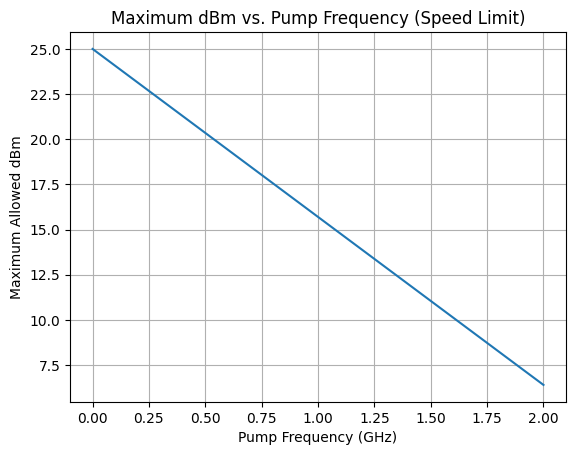

In [10]:
# assume a linear fit to Chao thesis ( Figure 63 Section 6.1.2  boundary to parametric interactions)
# Define the pump frequency range and the linear fit limits for the speed limit (maximum dBm vs. frequency)
xaxis = np.linspace(0, 2, 32)  # Pump frequency range in GHz
y_intercept = 25  # Starting dBm at 0 GHz
x_intercept = 2  # Frequency in GHz where dBm reaches 5
# Calculate slope for a line passing through (0, 25) and (2, 5)
slope = (5 - 25) / (x_intercept - 0)


def compute_max_dBm(frequency_GHz):
    """Computes the maximum allowable dBm for a given pump frequency using the refined linear fit."""
    return y_intercept + slope * frequency_GHz


def compute_snail_aware_max_dBm(frequency_GHz, snail_freq=4.3):
    """Computes the maximum allowable dBm for a given pump frequency using the refined linear fit."""
    intercept1 = (snail_freq / 2, 5)  # Starting dBm at 0 GHz
    y_intercept = (0, 25)  # Frequency in GHz where dBm reaches 5
    # Calculate slope for a line passing through (0, 25) and (2, 5)
    slope = (y_intercept[1] - intercept1[1]) / (y_intercept[0] - intercept1[0])
    return y_intercept[1] + slope * frequency_GHz


# Compute the speed limit line based on the linear fit provided
speed_limit_dBm = compute_snail_aware_max_dBm(xaxis)

# Plot the speed limit for maximum dBm vs. pump frequency
fig, ax = plt.subplots()
ax.plot(xaxis, speed_limit_dBm)
ax.set_xlabel("Pump Frequency (GHz)")
ax.set_ylabel("Maximum Allowed dBm")
ax.set_title("Maximum dBm vs. Pump Frequency (Speed Limit)")
plt.grid(True)
plt.show()

basically - for the evaluation, different gate frequency -> different durations -> different fidelity due to lifetime loss
in addition to crowding loss
and although we don't necessarily optimize super hard here - at least can be used to break symmetry, we prefer to line things up so are on the side of the band that is farther away eg

I am going to assume basic linear fit to Chao thesis ( Figure 63 Section 6.1.2  boundary to parametric interactions), then assume that for this setup, for simplicity, a 1Ghz gate (lambda = 0.1) gave a 100ns iSWAP. then can use this to fit a attenuation factor, how to relate pump dBM to epsilon: effective pump amplitude acting directly on the SNAIL. g3 = 60 MHz; w_snail=4.3GHz

use equation (7 preprint)
pi/2 = 6 t_f |eta| g_3 lambda^2
solve for eta

eta = pi/ (12 t_f g_3 lambda^2)
eta = (15 dBm * X_factor) * w_s / (w_pump^2 - w_snail^2)

then ... get some factor to convert dBm to epsilon (effective ampltiude - but I am unsure if using dB or linear units would be mroe sound)

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def fit_epsilon(dBm, t_f, g3, lambda_factor, w_pump, w_snail):
    """Fits the scaling factor (X_factor).

    Converts dBm pump power to epsilon for a specific iSWAP configuration. This scaling factor can then be applied
    for different frequencies and power levels.

    Parameters:
    dBm : float
        The pump power in dBm.
    t_f : float
        Gate duration in seconds.
    g3 : float
        Coupling strength parameter (in Hz).
    lambda_factor : float
        snail-qubit hybridization.
    w_pump : float
        Pump frequency in Hz.
    w_snail : float
        SNAIL resonant frequency in Hz.

    Returns:
    epsilon : float
        The effective amplitude of the pump power acting on the SNAIL.
    X_factor : float
        Scaling factor to convert dBm to epsilon.
    """
    # Convert dBm to linear power in mW
    # power_mW = 10 ** (dBm / 10)

    # Calculate eta using the iSWAP relationship
    eta = (np.pi) / (12 * t_f * g3 * lambda_factor**2)

    # Compute epsilon using the eta relationship
    epsilon = eta * (w_pump**2 - w_snail**2) / w_snail

    # Calculate the scaling factor X_factor to convert dBm to epsilon
    # X_factor = epsilon / power_mW
    X_factor = epsilon / dBm

    return epsilon, X_factor


def compute_gate_duration(frequency_GHz, X_factor, g3, lambda_factor, w_snail):
    """Computes the gate duration (t_f) for a given pump frequency using the fitted scaling factor
    and applying the maximum dBm speed limit.
    """  # noqa: D205
    # Convert pump frequency from GHz to Hz
    w_pump = 2 * np.pi * frequency_GHz * 1e9

    # Determine the maximum dBm allowed for this frequency
    max_dBm = compute_snail_aware_max_dBm(frequency_GHz)

    # Calculate epsilon using the speed limit (max_dBm)
    power_mW = 10 ** (max_dBm / 10)  # Convert max_dBm to mW
    # epsilon = X_factor * power_mW
    epsilon = X_factor * max_dBm

    # Calculate eta using the epsilon relationship
    eta = epsilon * w_snail / (w_pump**2 - w_snail**2)

    # Calculate the gate duration t_f using the iSWAP relationship
    t_f = np.pi / (12 * eta * g3 * lambda_factor**2)

    return t_f


# Example test values (based on assumptions in the setup)

t_f_test = 200e-9  # Gate duration in seconds (100 ns)
g3_test = 60e6  # Coupling strength (60 MHz)
lambda_factor_test = 0.1  # Scaling factor for 1 GHz gate frequency
test_ghz = 1.0  # ghz
w_pump_test = 2 * np.pi * test_ghz * 1e9  # Pump frequency of 1 GHz in Hz
dBm_test = compute_snail_aware_max_dBm(test_ghz)  # Example pump power in dBm
w_snail_test = 2 * np.pi * 4.3e9  # SNAIL frequency of 4.3 GHz in Hz

# Fit epsilon and scaling factor
epsilon_test, X_factor_test = fit_epsilon(
    dBm_test, t_f_test, g3_test, lambda_factor_test, w_pump_test, w_snail_test
)
print(epsilon_test, X_factor_test)
compute_gate_duration(
    test_ghz, X_factor_test, g3_test, lambda_factor_test, w_snail_test
)

-55755614010.029976 -3551839114.713021


2.0000000000000002e-07

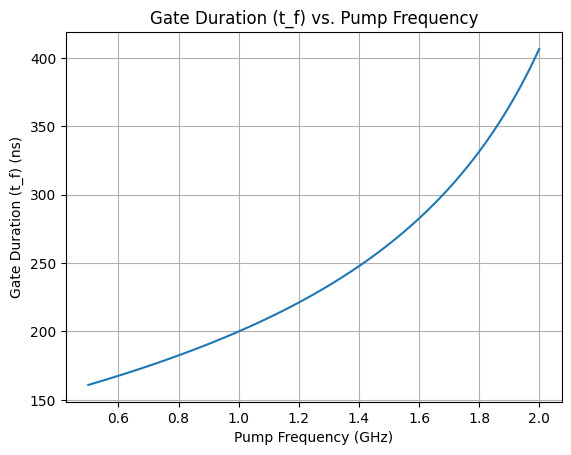

200.00000000000003

In [16]:
# Range of pump frequencies in GHz for the plot
frequency_range_GHz = np.linspace(0.5, 2.0, 100)  # from 0.5 GHz to 2.0 GHz

# Compute gate durations for each frequency in the range
gate_durations = [
    compute_gate_duration(f, X_factor_test, g3_test, lambda_factor_test, w_snail_test)
    for f in frequency_range_GHz
]

# Plotting t_f vs. pump frequency (GHz)
plt.figure()
plt.plot(
    frequency_range_GHz, np.array(gate_durations) * 1e9
)  # Convert gate durations to ns for readability
plt.xlabel("Pump Frequency (GHz)")
plt.ylabel("Gate Duration (t_f) (ns)")
plt.title("Gate Duration (t_f) vs. Pump Frequency")
plt.grid(True)
plt.show()

# Verify the gate duration at 1 GHz to see if it matches the fitting point of 100 ns
t_f_1GHz = compute_gate_duration(
    test_ghz, X_factor_test, g3_test, lambda_factor_test, w_snail_test
)
t_f_1GHz * 1e9  # Converting to ns for readability

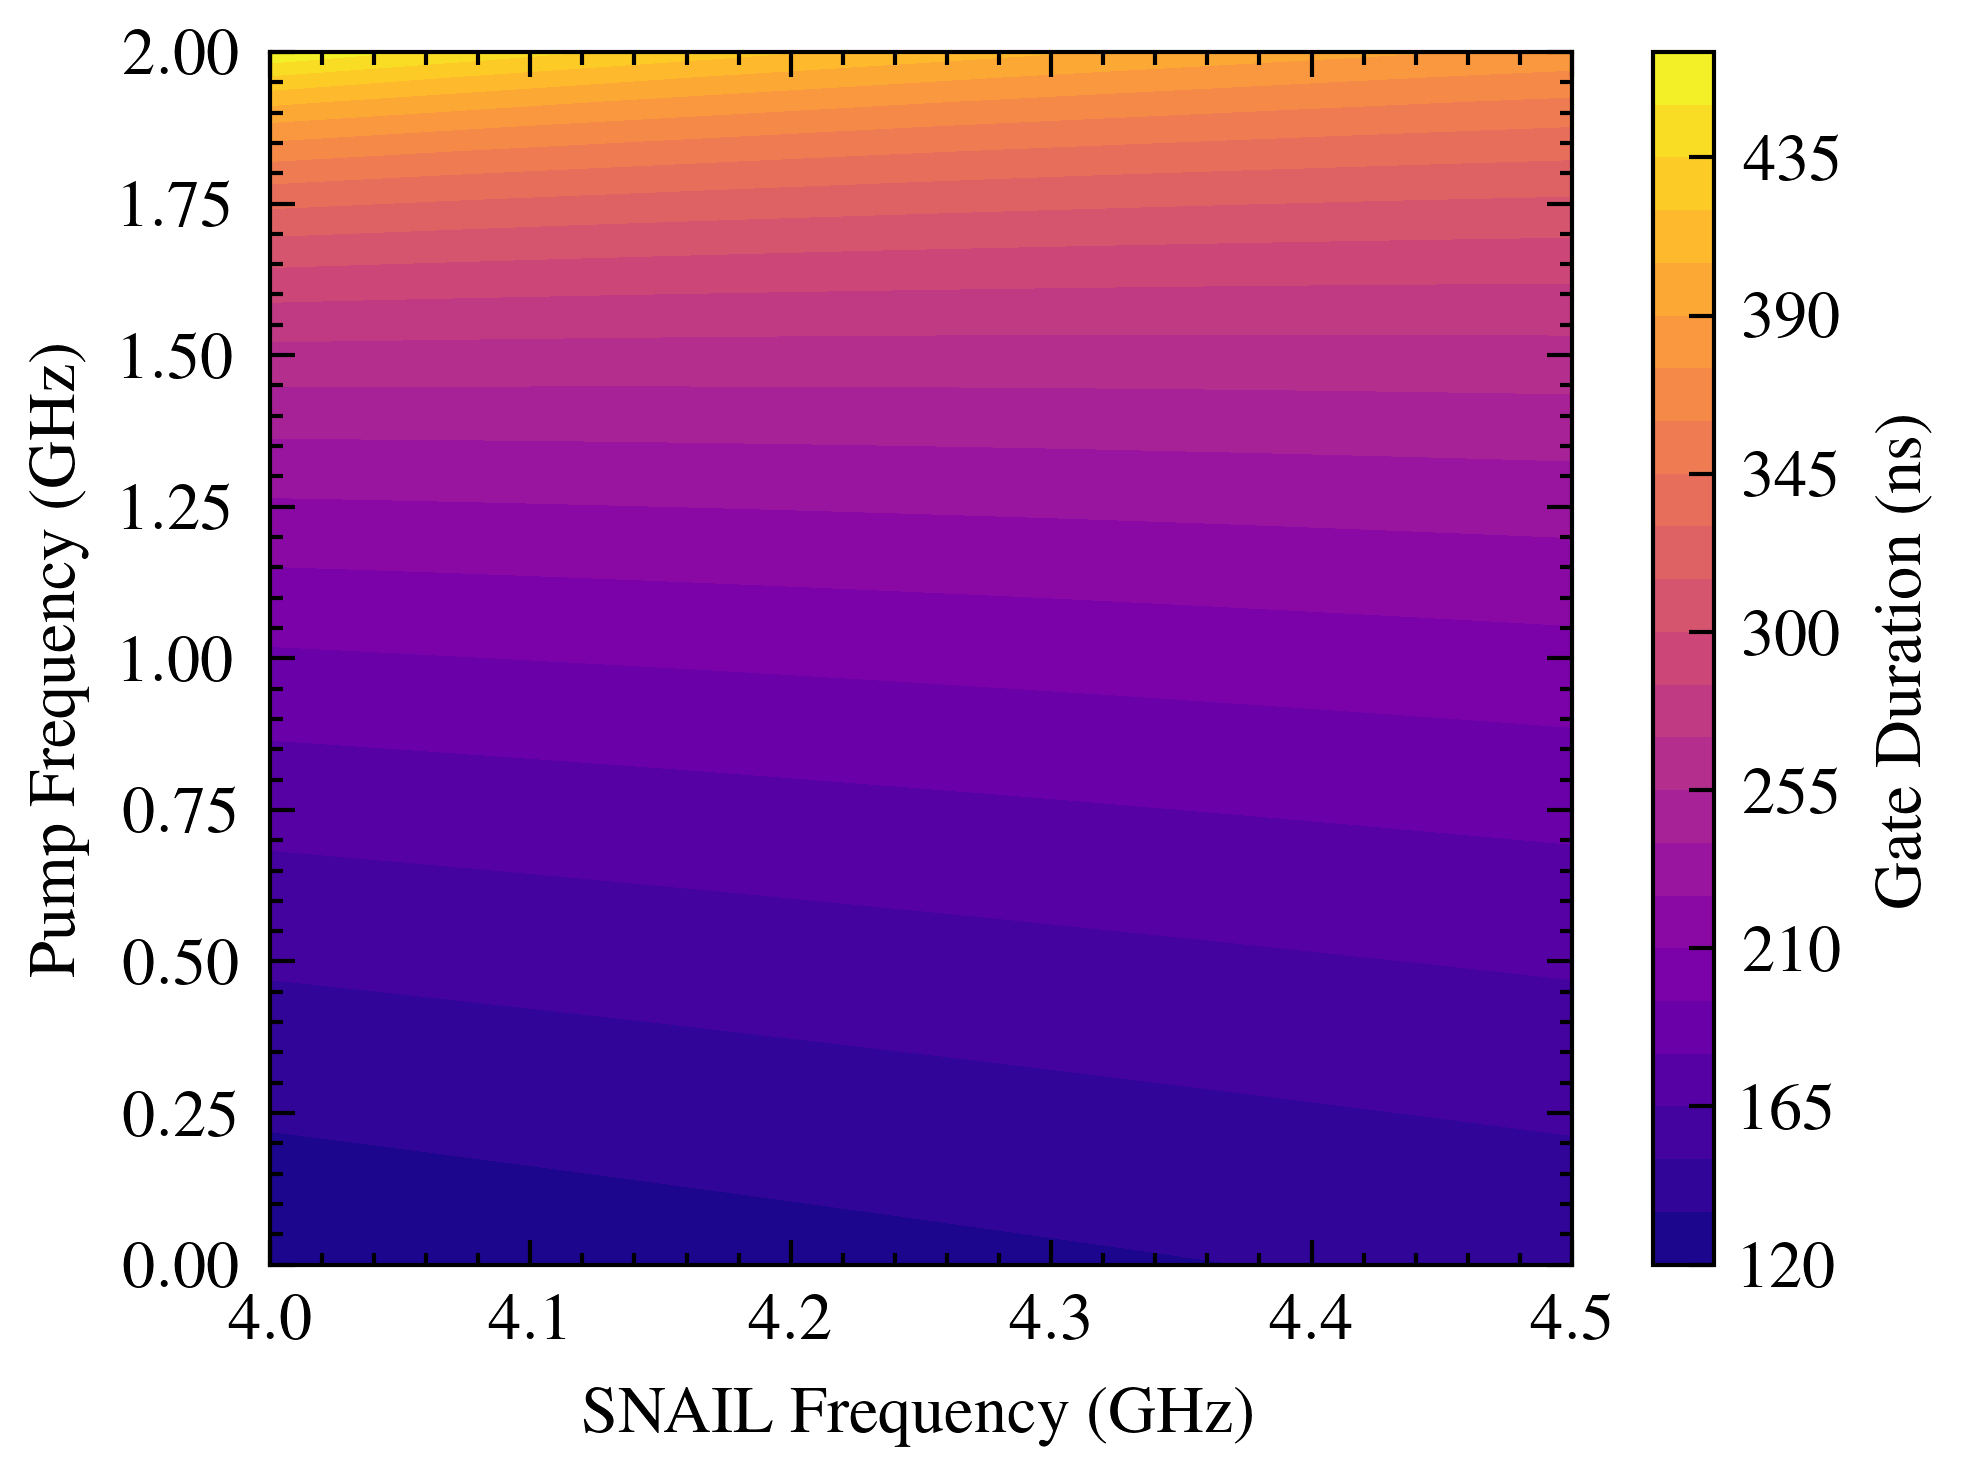

In [18]:
# We will create a 2D plot with gate duration as color vs. SNAIL frequency and pump frequency

# Set up a range of SNAIL and pump frequencies to create a meshgrid
snail_frequency_range_GHz = np.linspace(
    4, 4.5, 50
)  # SNAIL frequency range from 3.5 GHz to 5.0 GHz
pump_frequency_range_GHz = np.linspace(
    0.0, 2.0, 50
)  # Pump frequency range from 0.5 GHz to 2.0 GHz

# Create meshgrid for plotting
snail_freqs, pump_freqs = np.meshgrid(
    snail_frequency_range_GHz, pump_frequency_range_GHz
)

# Calculate gate duration for each pair of SNAIL and pump frequencies
gate_durations_2D = np.zeros_like(snail_freqs)

for i in range(snail_freqs.shape[0]):
    for j in range(snail_freqs.shape[1]):
        # Convert SNAIL frequency and pump frequency to Hz
        w_snail = 2 * np.pi * snail_freqs[i, j] * 1e9
        w_pump = 2 * np.pi * pump_freqs[i, j] * 1e9

        # Calculate the maximum dBm for the given pump frequency
        max_dBm = compute_snail_aware_max_dBm(pump_freqs[i, j], snail_freqs[i, j])

        # Calculate epsilon using the direct linear scaling assumption
        epsilon = X_factor_test * max_dBm

        # Calculate eta using epsilon and the off-resonance relationship
        eta = epsilon * w_snail / (w_pump**2 - w_snail**2)

        # Calculate the gate duration t_f using the iSWAP relationship
        t_f = np.pi / (12 * eta * g3_test * lambda_factor_test**2)

        # Store the gate duration in nanoseconds
        gate_durations_2D[i, j] = t_f * 1e9

# Plotting
with plt.style.context(["ieee", "use_mathtext", "science"]):
    # Plotting the gate duration as a heatmap
    plt.figure()
    plt.contourf(
        snail_frequency_range_GHz,
        pump_frequency_range_GHz,
        gate_durations_2D,
        levels=32,
        cmap="plasma",
    )
    plt.colorbar(label="Gate Duration (ns)")
    plt.xlabel("SNAIL Frequency (GHz)")
    plt.ylabel("Pump Frequency (GHz)")
    # plt.title("Gate Duration vs. SNAIL Frequency and Pump Frequency")
    plt.show()

fairly damaging to need to use a conversion gate between say a 4Ghz and 6Ghz qubit (larger the difference means slower gate  - because closer to the snail means way worse speed limit...)